<a href="https://colab.research.google.com/github/kimjaehwankimjaehwan/python_/blob/main/Predict_Future_Sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [124]:
# !unzip "/content/drive/MyDrive/data/competitive-data-science-predict-future-sales.zip"

https://www.kaggle.com/c/competitive-data-science-predict-future-sales/overview

* 대회 설명:
  이 대회는 Coursera 코스 "How to Win a Data Science Competition"의 최종 프로젝트로, 러시아의 대형 소프트웨어 회사인 1C Company에서 제공한 일별 판매 데이터를 사용합니다.

* 참가자는 매장과 제품별로 다음 달의 총 판매량을 예측해야 합니다. 이를 통해 시계열 데이터 분석 및 예측 모델링 실력을 향상시킬 수 있습니다.

* 평가 기준:
**Root Mean Squared Error (RMSE)**로 평가.
실제 목표 값은 [0, 20] 범위로 클리핑(잘라서 제한)됩니다.
제출 파일 형식:
테스트 세트의 각 ID에 대해 월간 총 판매량을 예측.
파일에는 헤더가 포함되어야 하며, 다음과 같은 형식을 따릅니다:

* 파일 설명:
  sales_train.csv: 2013년 1월부터 2015년 10월까지의 일별 판매 데이터로, 학습에 사용.
  test.csv: 2015년 11월의 매출 예측 대상 데이터.
  sample_submission.csv: 제출 형식에 맞춘 샘플 파일.
  items.csv: 제품에 대한 추가 정보 (제품명, 제품 ID 등).
  item_categories.csv: 제품 카테고리 정보.
  shops.csv: 상점에 대한 추가 정보.
* 데이터 필드 설명:
  ID: 테스트 세트에서 상점과 제품의 조합을 나타내는 ID.
  shop_id: 상점 고유 ID.
  item_id: 제품 고유 ID.
  item_category_id: 제품 카테고리 고유 ID.
  item_cnt_day: 일일 판매량. 예측할 목표는 월간 판매량.
  item_price: 제품 가격.
  date: 날짜 (dd/mm/yyyy 형식).
  date_block_num: 2013년 1월부터 순차적으로 부여된 월 번호 (예: 2013년 1월은 0, 2015년 10월은 33).
  item_name: 제품 이름.
  shop_name: 상점 이름.
  item_category_name: 제품 카테고리 이름.
* 주요 분석 및 예측 과제:
  - 월간 판매량 예측:
    - 일일 데이터를 월간 데이터로 변환해 총 판매량을 예측.
    - 상점과 제품의 변동성을 고려한 모델링 필요.
  - 데이터의 변동성 처리:
    - 매달 상점과 제품의 변화에 대비해 robust한 예측 모델 구축 필요.
    - 추가 정보 활용:
  - 제품 및 상점에 대한 메타 데이터를 활용해 모델의 예측 정확도를 높일 수 있음.
이 데이터를 활용해 상점별, 제품별 월간 판매량을 예측하는 것이 목표입니다.

In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [126]:
sales_train = pd.read_csv('/content/sales_train.csv')
items = pd.read_csv('/content/items.csv')
item_categories = pd.read_csv('/content/item_categories.csv')
shops = pd.read_csv('/content/shops.csv')
test = pd.read_csv('/content/test.csv')

In [127]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [128]:
sales_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [129]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [130]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [131]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [132]:
sales_train.merge(shops, on='shop_id', how = 'left').head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name
0,02.01.2013,0,59,22154,999.00,1.0,"Ярославль ТЦ ""Альтаир"""
1,03.01.2013,0,25,2552,899.00,1.0,"Москва ТРК ""Атриум"""
2,05.01.2013,0,25,2552,899.00,-1.0,"Москва ТРК ""Атриум"""
3,06.01.2013,0,25,2554,1709.05,1.0,"Москва ТРК ""Атриум"""
4,15.01.2013,0,25,2555,1099.00,1.0,"Москва ТРК ""Атриум"""


In [133]:
train = sales_train.merge(shops, on='shop_id', how = 'left')
train = train.merge(items, on='item_id', how = 'left')
train = train.merge(item_categories, on='item_category_id', how = 'left')

In [134]:
# 피처 요약표 만들기
train.describe(include= 'all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
date,2935849,1034,28.12.2013,9434,NaN,NaN,NaN,NaN,NaN,NaN,NaN
date_block_num,2935849.0,NaN,NaN,NaN,14.569911,9.422988,0.0,7.0,14.0,23.0,33.0
shop_id,2935849.0,NaN,NaN,NaN,33.001728,16.226973,0.0,22.0,31.0,47.0,59.0
item_id,2935849.0,NaN,NaN,NaN,10197.227057,6324.297354,0.0,4476.0,9343.0,15684.0,22169.0
item_price,2935849.0,NaN,NaN,NaN,890.853233,1729.799631,-1.0,249.0,399.0,999.0,307980.0
item_cnt_day,2935849.0,NaN,NaN,NaN,1.242641,2.618834,-22.0,1.0,1.0,1.0,2169.0
shop_name,2935849,60,"Москва ТЦ ""Семеновский""",235636,NaN,NaN,NaN,NaN,NaN,NaN,NaN
item_name,2935849,21807,Фирменный пакет майка 1С Интерес белый (34*42)...,31340,NaN,NaN,NaN,NaN,NaN,NaN,NaN
item_category_id,2935849.0,NaN,NaN,NaN,40.001383,17.100759,0.0,28.0,40.0,55.0,83.0
item_category_name,2935849,84,Кино - DVD,564652,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [135]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 10 columns):
 #   Column              Dtype  
---  ------              -----  
 0   date                object 
 1   date_block_num      int64  
 2   shop_id             int64  
 3   item_id             int64  
 4   item_price          float64
 5   item_cnt_day        float64
 6   shop_name           object 
 7   item_name           object 
 8   item_category_id    int64  
 9   item_category_name  object 
dtypes: float64(2), int64(4), object(4)
memory usage: 224.0+ MB


In [136]:
info_df = pd.DataFrame({
    'Column': train.columns,
    'Non-Null Count': [train[col].notnull().sum() for col in train.columns],
    'Dtype': train.dtypes
})

# 전치 적용
info_df = info_df.transpose()
info_df

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name
Column,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name
Non-Null Count,2935849,2935849,2935849,2935849,2935849,2935849,2935849,2935849,2935849,2935849
Dtype,object,int64,int64,int64,float64,float64,object,object,int64,object


In [137]:
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index() # Added parentheses to call the method
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values
    return summary

In [138]:
resumetable(train)

Dataset Shape: (2935849, 10)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value
0,date,object,0,1034,02.01.2013,03.01.2013,05.01.2013
1,date_block_num,int64,0,34,0,0,0
2,shop_id,int64,0,60,59,25,25
3,item_id,int64,0,21807,22154,2552,2552
4,item_price,float64,0,19993,999.0,899.0,899.0
5,item_cnt_day,float64,0,198,1.0,1.0,-1.0
6,shop_name,object,0,60,"Ярославль ТЦ ""Альтаир""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум"""
7,item_name,object,0,21807,ЯВЛЕНИЕ 2012 (BD),DEEP PURPLE The House Of Blue Light LP,DEEP PURPLE The House Of Blue Light LP
8,item_category_id,int64,0,84,37,58,58
9,item_category_name,object,0,84,Кино - Blu-Ray,Музыка - Винил,Музыка - Винил


In [139]:
import seaborn as sns
import matplotlib.pyplot as plt

<Axes: xlabel='item_cnt_day'>

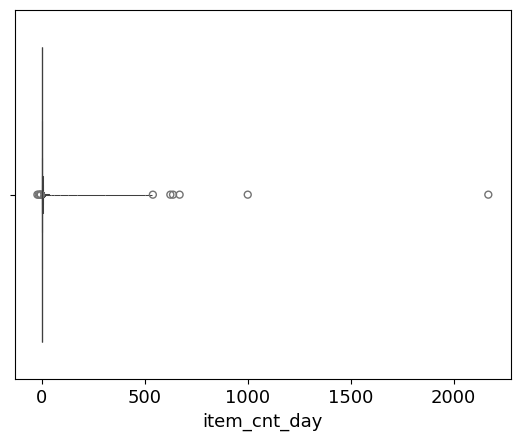

In [140]:
sns.boxenplot(data=train, x = 'item_cnt_day')

<Axes: xlabel='item_price'>

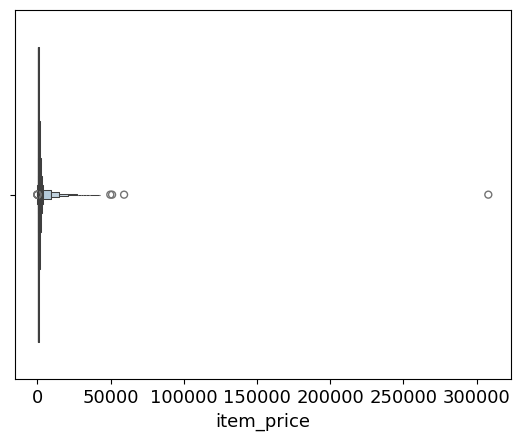

In [141]:
# 상품가격
sns.boxenplot(data=train, x = 'item_price')

In [142]:
group = train.groupby('date_block_num').agg({'item_cnt_day': 'sum'})
group

,item_cnt_day
date_block_num,
0,131479.0
1,128090.0
2,147142.0
3,107190.0
4,106970.0
5,125381.0
6,116966.0
7,125291.0
8,133332.0


<ipython-input-143-503dd164f876>:8: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  group_month_sum = train.groupby('date_block_num').agg({'item_cnt_day': sum})
<ipython-input-143-503dd164f876>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='date_block_num', y= 'item_cnt_day', data=group_month_sum, palette = palette, legend=False)


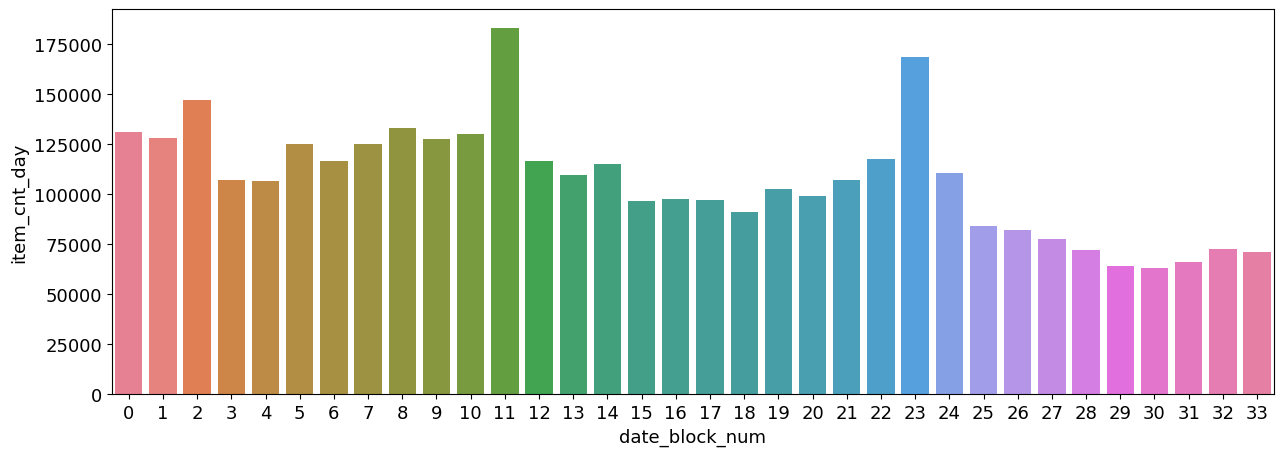

In [143]:
# 월별 판매량 시각화
import matplotlib as mpl
mpl.rc('font', size=13)
figure, ax = plt.subplots()
figure.set_size_inches(15,5)

# 월별 총 상품 판매량
group_month_sum = train.groupby('date_block_num').agg({'item_cnt_day': sum})
group_month_sum.reset_index(inplace=True)
# 월별 총 상품 판매량 막대 그래프
palette = sns.color_palette("husl", len(group_month_sum))
sns.barplot(x='date_block_num', y= 'item_cnt_day', data=group_month_sum, palette = palette, legend=False)
plt.show()

In [144]:
palette

[(0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 (0.9692894417585417, 0.4522225702495641, 0.4261820543616833),
 (0.9709475908389634, 0.46403989737619705, 0.23268163300341138),
 (0.890505610091069, 0.5199537141863416, 0.19575792074156828),
 (0.8233753136307219, 0.5564097629441267, 0.19515040910202758),
 (0.7683271076190015, 0.5816798170195111, 0.1946969920265838),
 (0.7188721694437208, 0.601448945129206, 0.19432336924941168),
 (0.6707067620542166, 0.6183981503261837, 0.19398957509205997),
 (0.6199256505009382, 0.6340974041174863, 0.19366913066077465),
 (0.5615229109598268, 0.6497101483863353, 0.19333954966604813),
 (0.48656894593750394, 0.6663726666050075, 0.19297564161091252),
 (0.3719375293111256, 0.6855530307409238, 0.19254095005558877),
 (0.19381360556293972, 0.7009873870290324, 0.2710533164704233),
 (0.1989376956463746, 0.6940313497882532, 0.4272539014485175),
 (0.20260140137245986, 0.6888777365691905, 0.5073931192355193),
 (0.20552427607615448, 0.6846548406076188, 0.5623139338264245),
 (0.20806612541243952, 0.6808998626985141, 0.6056504754121731),
 (0.21044753832183283, 0.6773105080456748, 0.6433941168468681),
 (0.21283940026780146, 0.6736342952276683, 0.6790583455137678),
 (0.21541566505718968, 0.6695930660637992, 0.7153920884875231),
 (0.21840821737392985, 0.6647898200401803, 0.7553445340026518),
 (0.22220544898465205, 0.6585210338454492, 0.8031687623961109),
 (0.2276041189151808, 0.6492591618617503, 0.8667352328785314),
 (0.2528186785662627, 0.6322661966470429, 0.9586861264495917),
 (0.46464649399867336, 0.6001189477477143, 0.9585131479964976),
 (0.590356051443871, 0.5672697683416862, 0.958348217126244),
 (0.690592305012026, 0.5310029892694575, 0.9581797268573365),
 (0.782279853549416, 0.48725654760876974, 0.9579950210252449),
 (0.8753266398274079, 0.4280264074507189, 0.9577762021967094),
 (0.9582498882450498, 0.36198809605341525, 0.9372277276912429),
 (0.9609894338512172, 0.3866875852472021, 0.8475770545475213),
 (0.9630327371699324, 0.40397639679071573, 0.771304184391217),
 (0.964715581208501, 0.4175934015417711, 0.6999430436310112),
 (0.9662183695417378, 0.4293305082631779, 0.6269197122023931)]

In [145]:
# 상품 분류별 판매량
group_cat_sum = train.groupby('item_category_name').agg({'item_cnt_day': sum})
group_cat_sum.reset_index(inplace=True)



<ipython-input-145-95e21c3f7f83>:2: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  group_cat_sum = train.groupby('item_category_name').agg({'item_cnt_day': sum})


In [146]:
group_cat_sum

,item_category_name,item_cnt_day
0,PC - Гарнитуры/Наушники,3.0
1,Аксессуары - PS2,2.0
2,Аксессуары - PS3,19597.0
3,Аксессуары - PS4,29807.0
4,Аксессуары - PSP,2407.0
...,...,...
79,Служебные,15830.0
80,Служебные - Билеты,6136.0
81,Чистые носители (шпиль),965.0
82,Чистые носители (штучные),10437.0


In [147]:
# 총판매량이 10000개를 초과하는 상품분류만 추출
group_cat_sum = group_cat_sum[group_cat_sum['item_cnt_day'] > 10000]

In [148]:
group_cat_sum

,item_category_name,item_cnt_day
2,Аксессуары - PS3,19597.0
3,Аксессуары - PS4,29807.0
6,Аксессуары - XBOX 360,20472.0
8,Билеты (Цифра),13699.0
9,Доставка товара,18118.0
12,Игровые консоли - PS4,13230.0
19,Игры - PS3,254887.0
20,Игры - PS4,127319.0
21,Игры - PSP,33066.0
22,Игры - PSVita,25123.0


<ipython-input-149-10d922ffcb5e>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='item_category_name', y= 'item_cnt_day', data=group_cat_sum, palette = palette, legend=False)


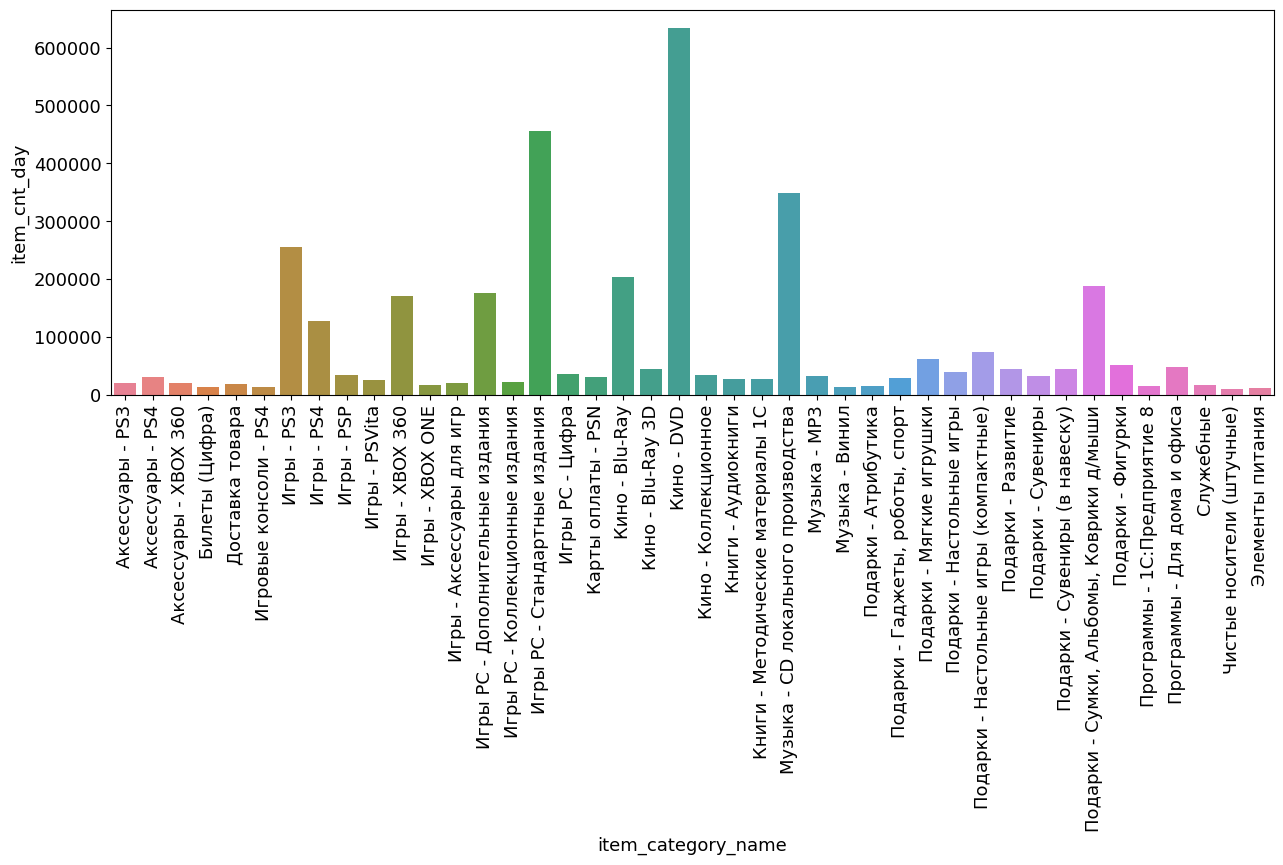

In [149]:
# 상품분류별 총 상품 판매량 막대그래프
figure, ax = plt.subplots()
figure.set_size_inches(15,5)
palette = sns.color_palette("husl", len(group_cat_sum))
sns.barplot(x='item_category_name', y= 'item_cnt_day', data=group_cat_sum, palette = palette, legend=False)
plt.xticks(rotation=90)
plt.show()

In [150]:
# 상점별 판매량
group_shop_sum = train.groupby('shop_name').agg({'item_cnt_day': sum})
group_shop_sum.reset_index(inplace=True)

<ipython-input-150-24b329208276>:2: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  group_shop_sum = train.groupby('shop_name').agg({'item_cnt_day': sum})


In [151]:
group_shop_sum.head()

,shop_name,item_cnt_day
0,"!Якутск Орджоникидзе, 56 фран",11705.0
1,"!Якутск ТЦ ""Центральный"" фран",6311.0
2,"Адыгея ТЦ ""Мега""",30620.0
3,"Балашиха ТРК ""Октябрь-Киномир""",28355.0
4,"Волжский ТЦ ""Волга Молл""",43942.0


In [152]:
group_shop_sum = group_shop_sum[group_shop_sum['item_cnt_day'] > 10000]

<ipython-input-153-0e059744a8e8>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='shop_name', y= 'item_cnt_day', data=group_shop_sum, palette = palette, legend=False)


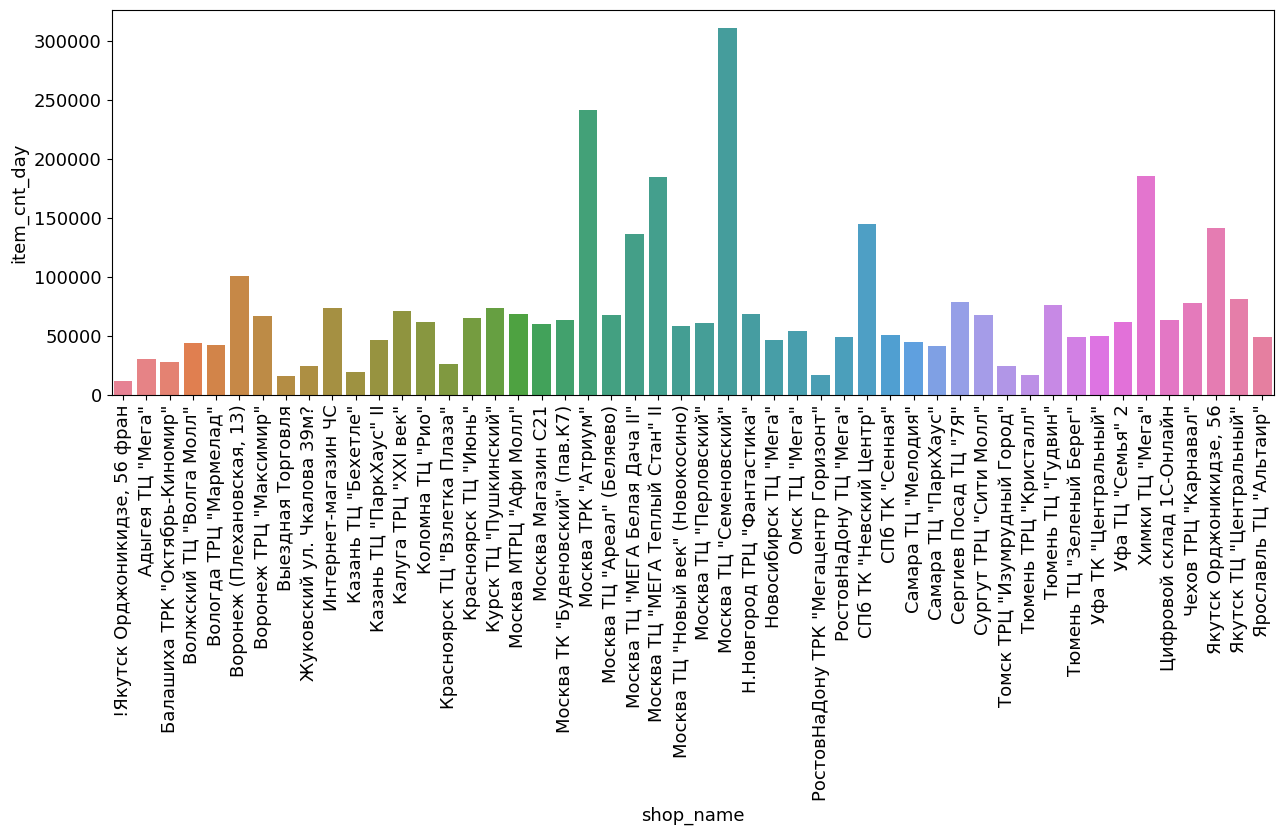

In [153]:
# 상점별 총 상품 판매량 막대그래프
figure, ax = plt.subplots()
figure.set_size_inches(15,5)
palette = sns.color_palette("husl", len(group_shop_sum))
sns.barplot(x='shop_name', y= 'item_cnt_day', data=group_shop_sum, palette = palette, legend=False)
plt.xticks(rotation=90)
plt.show()

In [154]:
# 모델 개발

In [155]:
# 피처 한글화
# 가독성차원에서
sales_train.rename(
    columns = {
        'date': '날짜',
        'date_block_num': '월',
        'shop_id': '상점ID',
        'item_id': '상품ID',
        'item_price': '가격',
        'item_cnt_day': '판매량'
    },
    inplace = True
)

In [156]:
sales_train.head()

,날짜,월,상점ID,상품ID,가격,판매량
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [157]:
shops.rename(
    columns = {
        'shop_name': '상점명',
        'shop_id': '상점ID',
    },
    inplace = True
)


In [158]:
shops

,상점명,상점ID
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9


In [159]:
items.rename(
    columns = {
        'item_name': '상품명',
        'item_id': '상품ID',
        'item_category_id': '상품분류ID'
    },
    inplace = True
)

In [160]:
items

,상품명,상품ID,상품분류ID
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
...,...,...,...
22165,"Ядерный титбит 2 [PC, Цифровая версия]",22165,31
22166,Язык запросов 1С:Предприятия [Цифровая версия],22166,54
22167,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,22167,49
22168,Яйцо для Little Inu,22168,62


In [161]:
item_categories.rename(
    columns = {
        'item_category_name': '상품분류명',
        'item_category_id': '상품분류ID'
    },
    inplace = True
)

In [162]:
item_categories

,상품분류명,상품분류ID
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
...,...,...
79,Служебные,79
80,Служебные - Билеты,80
81,Чистые носители (шпиль),81
82,Чистые носители (штучные),82


In [163]:
train.rename(
    columns = {
        'shop_name': '상점명',
        'shop_id': '상점ID',
        'item_name': '상품명',
        'item_id': '상품ID',
        'item_category_name': '상품분류명',
        'item_category_id': '상품분류ID',
        'date': '날짜',
        'date_block_num': '월',
        'item_price': '가격',
        'item_cnt_day': '판매량'
    },
    inplace = True
)

In [164]:
train

,날짜,월,상점ID,상품ID,가격,판매량,상점명,상품명,상품분류ID,상품분류명
0,02.01.2013,0,59,22154,999.00,1.0,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
1,03.01.2013,0,25,2552,899.00,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил
2,05.01.2013,0,25,2552,899.00,-1.0,"Москва ТРК ""Атриум""",DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил
3,06.01.2013,0,25,2554,1709.05,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил
4,15.01.2013,0,25,2555,1099.00,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства
...,...,...,...,...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0,"Москва ТРК ""Атриум""",V/A Nu Jazz Selection (digipack),55,Музыка - CD локального производства
2935845,09.10.2015,33,25,7460,299.00,1.0,"Москва ТРК ""Атриум""",V/A The Golden Jazz Collection 1 2CD,55,Музыка - CD локального производства
2935846,14.10.2015,33,25,7459,349.00,1.0,"Москва ТРК ""Атриум""",V/A The Best Of The 3 Tenors,55,Музыка - CD локального производства
2935847,22.10.2015,33,25,7440,299.00,1.0,"Москва ТРК ""Атриум""",V/A Relax Collection Planet MP3 (mp3-CD) (jewel),57,Музыка - MP3


In [165]:
test.rename(
    columns = {
        'shop_name': '상점명',
        'shop_id': '상점ID',
        'item_name': '상품명',
        'item_id': '상품ID',
        'item_category_name': '상품분류명',
        'item_category_id': '상품분류ID',
        'date': '날짜',
        'date_block_num': '월',
        'item_price': '가격',
        'item_cnt_day': '판매량'
    },
    inplace = True
)

In [166]:
test

,ID,상점ID,상품ID
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
...,...,...,...
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648


데이터 다운 캐스팅
- 메모리 절약
  - 큰 데이터 기본적으로 int64 float64 저장되는데 범위가 더 작은 데이터를 사용하면 int8, int16, float32
- 속도향상
- 불필요한 정밀도 제거
  - 정밀도가 필요하지 않은 데이터는 float32, float16
  

In [167]:
def downcast(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type_name = df[col].dtypes.name
        if col_type_name == 'object':
            pass
        elif col_type_name == 'bool':
            df[col] = df[col].astype('int8')
        elif col_type_name.startswith('int') or (df[col].round() == df[col]).all():
            df[col] = pd.to_numeric(df[col], downcast='integer')
        else:
            df[col] = pd.to_numeric(df[col], downcast='float')
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print(f'{100 * (start_mem - end_mem) / start_mem:.2f}% 메모리 절약됨')
        # 시각화: 메모리 사용량 변화 그래프
    fig, ax = plt.subplots(figsize=(5, 3))  # 그래프 크기를 조정
    colors = ['#ff9999', '#66b3ff']  # 부드러운 색상 사용 (핑크, 블루)
    ax.bar(['Before', 'After'], [start_mem, end_mem], color = colors)
    ax.set_ylabel('Memory Usage (MB)')
    ax.set_title('Memory Usage Before and After Optimization')
    plt.show()

    return df




In [168]:
sales_train['상점ID'].dtypes.name

'int64'

In [169]:
# (df[col].round() == df['col']).all()
sales_train.columns

Index(['날짜', '월', '상점ID', '상품ID', '가격', '판매량'], dtype='object')

In [170]:
sales_train['가격']

,가격
0,999.00
1,899.00
2,899.00
3,1709.05
4,1099.00
...,...
2935844,299.00
2935845,299.00
2935846,349.00
2935847,299.00


54.17% 메모리 절약됨


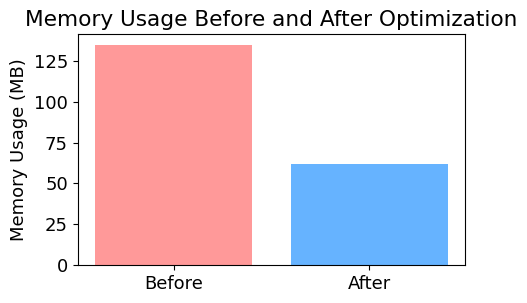

38.60% 메모리 절약됨


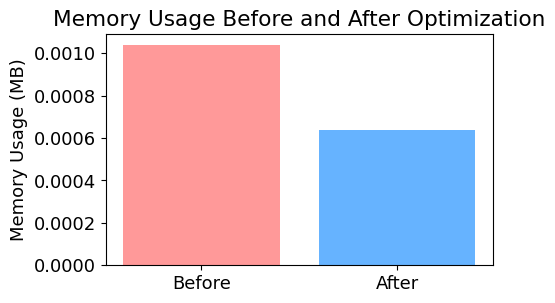

54.15% 메모리 절약됨


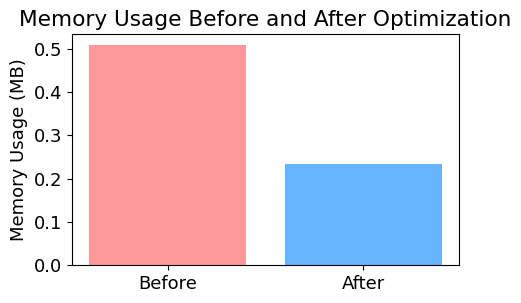

39.95% 메모리 절약됨


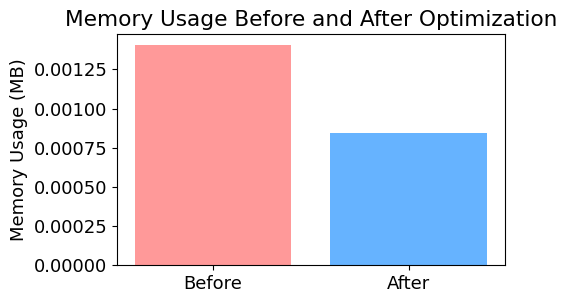

70.83% 메모리 절약됨


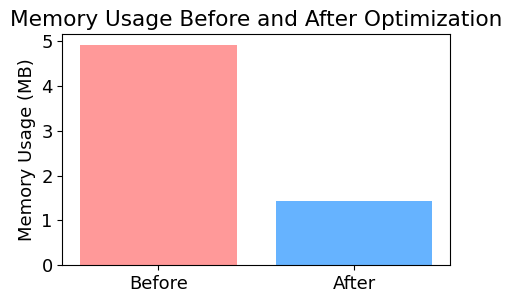

In [171]:
all_df = [sales_train, shops, items, item_categories, test]
for df in all_df:
  df = downcast(df)

피처 엔지니어링 : 파생변수생성

In [172]:
sales_train.head()

,날짜,월,상점ID,상품ID,가격,판매량
0,02.01.2013,0,59,22154,999.00,1
1,03.01.2013,0,25,2552,899.00,1
2,05.01.2013,0,25,2552,899.00,-1
3,06.01.2013,0,25,2554,1709.05,1
4,15.01.2013,0,25,2555,1099.00,1


In [173]:
sales_train[sales_train['월'] == 1]

,날짜,월,상점ID,상품ID,가격,판매량
115690,21.02.2013,1,50,3880,1499.0,1
115691,14.02.2013,1,50,3880,1499.0,1
115692,21.02.2013,1,50,4128,899.0,1
115693,13.02.2013,1,50,4124,249.0,1
115694,24.02.2013,1,50,3880,1499.0,1
...,...,...,...,...,...,...
224298,23.02.2013,1,28,13511,1599.0,2
224299,26.02.2013,1,28,13511,1599.0,1
224300,18.02.2013,1,28,13413,1999.0,1
224301,20.02.2013,1,28,13413,1999.0,1


In [174]:
from itertools import product
all_shop = sales_train.loc[sales_train['월']==1, '상점ID'].unique()
all_item = sales_train.loc[sales_train['월']==1, '상품ID'].unique()
# list(product(all_shop, all_item))
list(zip(all_shop,all_item))

[(50, 3880),
 (47, 4128),
 (51, 4124),
 (52, 3879),
 (42, 3885),
 (46, 3950),
 (43, 4163),
 (54, 3897),
 (56, 3941),
 (59, 3959),
 (7, 4036),
 (53, 3983),
 (16, 3993),
 (18, 4127),
 (19, 3890),
 (14, 4115),
 (15, 3878),
 (13, 3834),
 (23, 3850),
 (24, 3851),
 (21, 3788),
 (25, 3805),
 (22, 3869),
 (4, 3870),
 (3, 3871),
 (5, 4164),
 (1, 4244),
 (2, 4245),
 (6, 4248),
 (0, 4249),
 (8, 4251),
 (12, 4266),
 (10, 4092),
 (31, 4282),
 (32, 4241),
 (35, 4227),
 (44, 4240),
 (41, 3508),
 (45, 3328),
 (37, 3321),
 (38, 3322),
 (26, 3360),
 (27, 3362),
 (29, 3366),
 (30, 3367),
 (28, 3320)]

In [175]:
sales_train['월'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33],
      dtype=int8)

In [176]:
# Train = []
# for i in sales_train['월'].unique():
#   all_shop = sales_train.loc[sales_train['월']==i, '상점ID'].unique()
#   all_item = sales_train.loc[sales_train['월']==i, '상품ID'].unique()
#   print(len(all_shop))
#   Train.append(list(zip([i],all_shop, all_item)))
# Train = pd.DataFrame(np.vstack(Train), columns = ['월','상점ID', '상품ID'])
# Train


Train = []

# '월'에 대한 unique 값으로 반복
for i in sales_train['월'].unique():
    # 해당 월에 대한 상점ID와 상품ID 추출
    all_shop = sales_train.loc[sales_train['월'] == i, '상점ID'].unique()
    all_item = sales_train.loc[sales_train['월'] == i, '상품ID'].unique()

    # 각각의 상점과 상품 조합을 만들어 Train 리스트에 추가
    for shop in all_shop:
        for item in all_item:
            Train.append([i, shop, item])

# Train 리스트를 DataFrame으로 변환
Train = pd.DataFrame(Train, columns=['월', '상점ID', '상품ID'])

# 결과 출력
Train.head()


,월,상점ID,상품ID
0,0,59,22154
1,0,59,2552
2,0,59,2554
3,0,59,2555
4,0,59,2564


In [177]:
Train.shape

(10913850, 3)

월간 판매량

In [178]:
group = sales_train.groupby(['월', '상점ID', '상품ID']).agg({'판매량': 'sum'})
group.reset_index(inplace=True)
group.rename(columns={'판매량': '월간판매량'}, inplace=True)
group.head()

,월,상점ID,상품ID,월간판매량
0,0,0,32,6
1,0,0,33,3
2,0,0,35,1
3,0,0,43,1
4,0,0,51,2


In [179]:
group

,월,상점ID,상품ID,월간판매량
0,0,0,32,6
1,0,0,33,3
2,0,0,35,1
3,0,0,43,1
4,0,0,51,2
...,...,...,...,...
1609119,33,59,22087,6
1609120,33,59,22088,2
1609121,33,59,22091,1
1609122,33,59,22100,1


In [180]:
# 가비지 컬렉터 .. 메모리 정리.. 원래는 운영체제가 안쓰는 메모리를 모니터링하고 있다가 정리 --> 수동지금실행
import gc
del sales_train # 더이상 사용하지 않는 변수라고 알려주고
gc.collect()  # 가비지 컬렉터 실행

0

In [181]:
##테스트 데이터 병합
all_data = pd.concat([Train, test.drop('ID', axis=1)], ignore_index=True, keys=Train.columns)
all_data.sort_values(by=['월', '상점ID', '상품ID'], inplace=True)

<ipython-input-181-266aefd40741>:2: FutureWarning: The behavior of pd.concat with len(keys) != len(objs) is deprecated. In a future version this will raise instead of truncating to the smaller of the two sequences
  all_data = pd.concat([Train, test.drop('ID', axis=1)], ignore_index=True, keys=Train.columns)


In [182]:
all_data.fillna(0, inplace=True)


In [183]:
# 나머지 데이터도 병합
all_data = pd.merge(all_data, group, on=['월', '상점ID', '상품ID'], how='inner', suffixes=('_left', '_right')) # Add suffixes to differentiate columns with the same name
all_data = pd.merge(all_data, items, on=['상품ID'], how='inner', suffixes=('_left', '_right'))
all_data = pd.merge(all_data, item_categories, on=['상품분류ID'], how='inner', suffixes=('_left', '_right'))
all_data = pd.merge(all_data, shops, on=['상점ID'], how='inner', suffixes=('_left', '_right'))


In [184]:
all_data.head()

,월,상점ID,상품ID,월간판매량,상품명,상품분류ID,상품분류명,상점명
0,0.0,0,32,6,1+1,40,Кино - DVD,"!Якутск Орджоникидзе, 56 фран"
1,1.0,0,32,10,1+1,40,Кино - DVD,"!Якутск Орджоникидзе, 56 фран"
2,0.0,0,35,1,10 ЛЕТ СПУСТЯ,40,Кино - DVD,"!Якутск Орджоникидзе, 56 фран"
3,1.0,0,35,14,10 ЛЕТ СПУСТЯ,40,Кино - DVD,"!Якутск Орджоникидзе, 56 фран"
4,0.0,0,43,1,100 МИЛЛИОНОВ ЕВРО,40,Кино - DVD,"!Якутск Орджоникидзе, 56 фран"
